## Линейная регрессия

In [276]:
import pandas as pd
dataset = pd.read_csv('Fish.csv')

In [277]:
dataset.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


### постараемся предсказать вес рыбы по другим параметрам

In [278]:
y = dataset['Weight'].values
x = dataset[['Length1','Length2', 'Length3','Height','Width']].values

### нормализуем данные

In [279]:
x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

(array([27., 32., 13., 18.,  6.,  6., 12.,  6., 12.,  4.,  5.,  6.,  6.,
         2.,  0.,  1.,  0.,  0.,  1.,  2.]),
 array([-1.1162267 , -0.88503765, -0.65384861, -0.42265957, -0.19147053,
         0.03971852,  0.27090756,  0.5020966 ,  0.73328564,  0.96447468,
         1.19566373,  1.42685277,  1.65804181,  1.88923085,  2.1204199 ,
         2.35160894,  2.58279798,  2.81398702,  3.04517606,  3.27636511,
         3.50755415]),
 <a list of 20 Patch objects>)

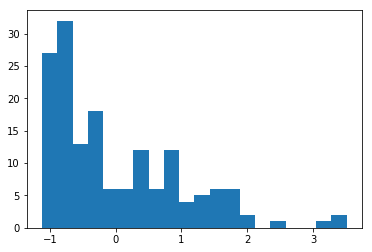

In [280]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(y, bins=20)

In [281]:
import numpy as np
np.random.seed(42)

### 
Данные нужно разделить в отношении 80/20 на обучающую и валидационную выборки. 

In [282]:
pivot = int(len(y) * 0.8)
index = np.arange(len(dataset))
np.random.shuffle(index)

train_index, val_index = index[:pivot], index[pivot:]

y_train, y_val = y[train_index], y[val_index]
x_train, x_val = x[train_index], x[val_index]

In [283]:
import tensorflow as tf

### Инициализация

Воспользуйтесь x.shape, чтобы задать правильную размерность вектора с параметрами. Проинициализируйте его случайными значениями.

**Значение сдвига** `b = 0`; часто сдвиг или вектор сдвигов инициализируют нулями или средним по выборке значением, если оно отлично от нуля.

In [284]:
import random
x.shape[1:]

(5,)

In [285]:
initial_value = tf.random.normal(shape=(5,))
w = tf.Variable(initial_value, dtype=tf.float32)

In [286]:
initial_value = tf.random.normal(shape=(5,))
w =  tf.Variable(initial_value, dtype=tf.float32)
b = tf.Variable(0, dtype=tf.float32)
learning_rate = tf.constant(1e-4)

In [287]:
w

<tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=
array([-0.4603077 ,  0.18801455,  0.2730891 ,  0.18656167,  0.4674958 ],
      dtype=float32)>

In [288]:
w.dtype


tf.float32

In [289]:
def fit(x, y, threshold=0.001, n_steps=10000):
    x = tf.constant(x, dtype=tf.float32)
    y = tf.constant(y, dtype=tf.float32)
    for step in range(n_steps):
        loss = train_step(x, y)
        if loss < threshold:
            break
        if (step + 1) % 50 == 0:
            print(f"Loss at {step} iter. is {loss.numpy()}")
    return loss

### Train step

Дополните `train_step` так, чтобы функция вычисляла значение $\hat{y}$ для переданного $x$, и затем значение функции ошибки с помощью функции `calc_loss`.

Добавитье обновление параметров в строчке `w = ...`. *Если возвращаемое значение* функции ошибки равно `nan` или `inf`, подумайте, что могло привести к такой ситуации и что нужно исправить.

In [290]:
def train_step(x, y):
    global w
    with tf.GradientTape() as tape:
        y_hat = model(x)
        loss = calc_loss(y, y_hat)
        grads = tape.gradient(loss, w)
        #print(grads)
    w.assign_sub(grads * 0.001)
    return loss

Умножение вектора на вектор или вектора на строку в `tf` - это сложная операция. В отличие от матричного умножения, которое можно записать просто как `C = A @ B` или `C = tf.matmul(A, B)`, здесь нужно вызывать функцию `tf.tensordot`, которая способна умножать тензоры любой размерности. Затем функции надо указать ось, по которой выполняется сложение: в данном случае, 1 - т.е. для произведения матрицы на вектор нужно выполнить операцию

`tf.tensordot(x, w, 1)`

Воспользовавшись этим способом, напишите модель для линейной регрессии. Кстати, это не единственный возможный вариант [расчета скалярного произведения в tensorflow](https://stackoverflow.com/questions/40670370/dot-product-of-two-vectors-in-tensorflow).

In [291]:
def model(x):
    global w
    return(tf.tensordot(x, w, 1))

Напишите функцию, которая вычисляет значение MSE для двух переданных векторов со значениями $y, \hat{y}$ (истинные и спрогнозированные значения). Функция должна возвращать _одно_ значение (скаляр), как и в формуле $\frac{1}{n}\sum_{i=1}^{n}(y^{(i)} - \hat{y}^{(i)})^2$ 

* разность векторов и возведение в квадрат можно сделать при помощи обычных операторов `-`, `**2`
* Для того, чтобы в тензорфлоу выполнить аналог операции $\frac{1}{n}\sum_{i=1}^n (...)$, воспользуйтесь функцией `tf.reduce_mean`. Заодно можете изучить, какие еще есть `tf.reduce_...` функции :)

In [292]:
def calc_loss(y, y_hat):
    x = tf.reduce_mean((y - y_hat)**2)
    return(x)

## обучим модель

In [293]:
fit(x_train, y_train)

Loss at 49 iter. is 0.6657382845878601
Loss at 99 iter. is 0.4110798239707947
Loss at 149 iter. is 0.2908097803592682
Loss at 199 iter. is 0.2310338169336319
Loss at 249 iter. is 0.19914230704307556
Loss at 299 iter. is 0.1806071251630783
Loss at 349 iter. is 0.16884712874889374
Loss at 399 iter. is 0.16079741716384888
Loss at 449 iter. is 0.15496587753295898
Loss at 499 iter. is 0.15057843923568726
Loss at 549 iter. is 0.1471995711326599
Loss at 599 iter. is 0.14456145465373993
Loss at 649 iter. is 0.14248527586460114
Loss at 699 iter. is 0.14084407687187195
Loss at 749 iter. is 0.13954336941242218
Loss at 799 iter. is 0.13851089775562286
Loss at 849 iter. is 0.13769055902957916
Loss at 899 iter. is 0.13703832030296326
Loss at 949 iter. is 0.13651937246322632
Loss at 999 iter. is 0.13610631227493286
Loss at 1049 iter. is 0.13577726483345032
Loss at 1099 iter. is 0.1355149745941162
Loss at 1149 iter. is 0.13530570268630981
Loss at 1199 iter. is 0.13513854146003723
Loss at 1249 iter. is

<tf.Tensor: id=1248173, shape=(), dtype=float32, numpy=0.13396046>

### Напишите функцию для оцени качества модели

Функция должна принимать на вход данные и значение целевой переменной возвращать значение ошибки (скаляр). Сравните ошибку на обучающей и валидационной выборке, сделайте выводы о том, переобучена ли модель.

Буду использовать $R^2$ - коэффициент детерминации. Высчитывается по формуле $1 -\frac{\sum_{i=1}^{n}(y^{(i)} - \hat{y}^{(i)})^2}{\sum_{i=1}^{n}(y^{(i)} - \bar{y}^{(i)})^2}$

In [294]:
def evaluate(x, y):
    x = tf.constant(x, dtype=tf.float32)
    y = tf.constant(y, dtype=tf.float32)
    y_hat = model(x)
    sum2 =(tf.reduce_sum((y - tf.reduce_mean(y))**2))
    sum1 = (tf.reduce_sum((y - y_hat)**2))
    return(1 - sum1/sum2)

In [295]:
evaluate(x_train, y_train)

<tf.Tensor: id=1248225, shape=(), dtype=float32, numpy=0.8794145>

In [296]:
evaluate(x_val, y_val)

<tf.Tensor: id=1248254, shape=(), dtype=float32, numpy=0.76172554>

## ВЫВОДЫ
Да, разница в коэффициенте детерминации есть - у обучающей этот показзатель выше. С другой стороный показатель в 0.724 тоже очень хорош и модель может быть использована для прогонозов. Исходя из этого - да, модель преобучена

# 2. Слой Linear

* Дополните линейный слой так, чтобы у него появились веса для сдвига. Для этого используйте метод `add_weight`. Размерность вектора с весами для сдвига равно размерности слоя на выходе (параметр `units`). 
* Для инициализации сдвига _нулями_ передайте `tf.keras.initializers.Zeros()` в качестве значения для параметра `add_weight(..., initializer=...)` 
* Измените метод `call` так, чтобы он использовал сдвиги.
* Обучите модель на тех же данных, что и в первом задании.

In [324]:
class Linear(tf.keras.layers.Layer):
    def __init__(self, units, initializer='glorot_uniform', **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.initializer = keras.initializers.get(initializer)
    
    def build(self, input_shape):
        self.kernel = self.add_weight(
        shape=(input_shape[-1], self.units),
        initializer=self.initializer,
        name="kernel",
        trainable=True,
        )
        self.baes = self.add_weight(
        shape=(input_shape[-1], self.units),
        initializer=tf.keras.initializers.Zeros(),
        name="baes",
        trainable=True,
        )

  
    def call(self, inputs):#добавить сдвиг
        print()
        return tf.matmul(inputs  , self.kernel + self.baes)

## Запустите модель и сравните результаты с моделью из п.1

In [325]:
import tensorflow.keras as keras
import os
import datetime


logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

linear_layer = Linear(1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               min_delta=1e-4)
model = keras.models.Sequential([linear_layer])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
              loss='mse')

> **Обратите внимание**, что добавился параметр `validation_data`, а в `EarlyStopping` в ячейке выше значение параметра `monitor` заменено на `val_loss`!

In [326]:
history = model.fit(x_train, np.expand_dims(y_train, axis=-1), 
                    validation_data=(x_val, y_val),
                    batch_size=512,
                    epochs=100,
                    callbacks=[early_stopping, tensorboard],
                    verbose=1)


Train on 127 samples, validate on 32 samples
Epoch 1/100



127/127 [==============================] - 0s 4ms/sample - loss: 1.6550 - val_loss: 1.6572
Epoch 2/100
127/127 [==============================] - 0s 163us/sample - loss: 1.4797 - val_loss: 1.4688
Epoch 3/100
127/127 [==============================] - 0s 176us/sample - loss: 1.3318 - val_loss: 1.3087
Epoch 4/100
127/127 [==============================] - 0s 188us/sample - loss: 1.2054 - val_loss: 1.1717
Epoch 5/100
127/127 [==============================] - 0s 225us/sample - loss: 1.0961 - val_loss: 1.0536
Epoch 6/100
127/127 [==============================] - 0s 190us/sample - loss: 1.0005 - val_loss: 0.9512
Epoch 7/100
127/127 [==============================] - 0s 246us/sample - loss: 0.9164 - val_loss: 0.8617
Epoch 8/100
127/127 [==============================] - 0s 197us/sample - loss: 0.8417 - val_loss: 0.7833
Epoch 9/100
127/127 [==============================] - 0s 217us/sample - loss: 0.7750 - val_loss: 0.7141
Epoch 10

## Tensorboard
> Выведите полученные результаты в tensorboard. Это сервис, который позволяет визуализировать процесс обучения модели, состояние графа и не только. 

Для запуска нужно 
* Установить расширение
* Выполнить команду запуска, передав ей имя директории, в которую записывал логи `callbacks.Tensorboard`.

Более подробно изучим tensorboard на будущих занятиях. Пока можете посмотреть вкладки scalars, graphs, distributions, histograms. В них содержится информация о метриках модели, графе, распередлениях и гистограммах параметров.

In [328]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [345]:
%tensorboard --logdir='logs' 

In [344]:
!kill 3019